In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist
import keras
from scipy import signal

In [4]:
class Activation:
    def __init__(self , activation , activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self,input):
        self.input = input
        return self.activation(self.input) #pass the input to the activation function

    def backward(self , output_gradient , learning_rate): #returning the reviced error from front layer and applying the derivative of the activation function
        return np.multiply(output_gradient , self.activation_prime(self.input))   #product of the dervatives from the activation fn and the output gradient from

#forward and backward pass functions added

In [5]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass

In [36]:
class Tanh(Activation):
    def __init__(self):

        def tanh(x):
            return np.tanh(x) #tanh function from np

        def tanh_prime(x): #derivatice of tanh
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime) #super class keyword used to acess the values

class Sigmoid(Activation):
    def __init__(self):

        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

class Softmax(Layer):  #Soft_max Activation Function made over here with the forwards and backward pass..
    def forward(self, input):
        # 1. Stable Softmax: Subtract the maximum input value (C)
        # This shifts the inputs down, preventing the exponent from overflowing,
        # but does not change the resulting probabilities.
        exp_input = input - np.max(input) #added to prevent the overflow
        tmp = np.exp(exp_input)
        self.output = tmp / np.sum(tmp)
        return self.output

    def backward(self, output_gradient, learning_rate):
        # This version is faster than the one presented in the video
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)

        # Original formula:
        # tmp = np.tile(self.output, n)
        # return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)

class ReLU(Activation):
    def __init__(self):

        # 1. The ReLU function itself: R(x) = max(0, x)
        def relu(x):
            # If the input element x is greater than 0, return x; otherwise, return 0.
            return np.maximum(0, x)

        # 2. The derivative of the ReLU function
        def relu_prime(x):
            # The derivative is 1 if x > 0, and 0 if x <= 0.
            # We use a simple comparison and cast the boolean result to an integer (0 or 1).
            return (x > 0).astype(int)
        super().__init__(relu, relu_prime)

V2 of the above functions with changes

In [31]:
class Tanh(Activation):
    def __init__(self):

        def tanh(x):
            return np.tanh(x) #tanh function from np

        def tanh_prime(x): #derivatice of tanh
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime) #super class keyword used to acess the values

class Sigmoid(Activation):
    def __init__(self):

        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

class Softmax(Layer):  #Soft_max Activation Function made over here with the forwards and backward pass..
    def forward(self, input):

        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output

#     def backward(self, output_gradient, learning_rate): #V1
#         # This version is faster than the one presented in the video
#         n = np.size(self.output)
#         return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)

#         # Original formula:
#         # tmp = np.tile(self.output, n)
#         # return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)

    def backward(self, output_gradient, learning_rate):  #Faster implementation V2
        # The backward pass is now handled by the CCE function,
        # so Softmax acts as a simple pass-through for the gradient
        return output_gradient

class ReLU(Activation):
    def __init__(self):

        # 1. The ReLU function itself: R(x) = max(0, x)
        def relu(x):
            # If the input element x is greater than 0, return x; otherwise, return 0.
            return np.maximum(0, x)

        # 2. The derivative of the ReLU function
        def relu_prime(x):
            # The derivative is 1 if x > 0, and 0 if x <= 0.
            # We use a simple comparison and cast the boolean result to an integer (0 or 1).
            return (x > 0).astype(int)
        super().__init__(relu, relu_prime)

In [34]:
#various loss function with their derivatives here

import numpy as np

def mse(y_true , y_pred):
    # return 0.5*(y_true - y_pred)**2
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true , y_pred):
    return 2 * (y_true - y_pred)/np.size(y_true)

def binary_cross_entropy(y_true , y_pred):
    # return 0.5*(-y_true * np.log(y_pred) - (1 - y_true)*np.log(1 - y_pred)) #only two values for binary cross entropy function
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true)*np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true , y_pred):
    # return ( (1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    grad = (y_pred - y_true) / (y_pred * (1 - y_pred))
    return grad / np.size(y_true)

def categorical_cross_entropy(y_true , y_pred):
    # Clip probabilities to avoid log(0) which results in infinite loss.The smallest number should be larger than 0.
    y_pred = np.clip(y_pred, 1e-12, 1.0)

    # Loss formula: - (1/N) * sum(y_true * log(y_pred))
    # where the sum is over all classes and all samples (N).
    # np.sum(y_true * np.log(y_pred)) effectively only includes the log(predicted probability)
    # for the correct (one-hot) class.
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

def categorical_cross_entropy_prime(y_true , y_pred):
    # Clip probabilities to avoid division by zero.
    y_pred = np.clip(y_pred, 1e-12, 1.0)

    # Gradient w.r.t. the prediction: - (1/N) * (y_true / y_pred)
    # This is the derivative of the mean loss w.r.t. the Softmax output (y_pred).
    grad = -y_true / y_pred
    # Divide by the number of samples (N) to account for the mean loss.
    return grad / y_true.shape[0]

V2 of the above code given trying some changes

In [32]:
def mse(y_true , y_pred):
    # return 0.5*(y_true - y_pred)**2
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true , y_pred):
    return 2 * (y_true - y_pred)/np.size(y_true)

def binary_cross_entropy(y_true , y_pred):
    # return 0.5*(-y_true * np.log(y_pred) - (1 - y_true)*np.log(1 - y_pred)) #only two values for binary cross entropy function
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15) #for clippping the output when it goes to -inf in any case and prevents NaN error
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true)*np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true , y_pred):
    # return ( (1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    grad = (y_pred - y_true) / (y_pred * (1 - y_pred))
    return grad / np.size(y_true)

def categorical_cross_entropy(y_true , y_pred):
    # Clip probabilities to avoid log(0) which results in infinite loss.The smallest number should be larger than 0.
    y_pred = np.clip(y_pred, 1e-12, 1.0)

    # Loss formula: - (1/N) * sum(y_true * log(y_pred))
    # where the sum is over all classes and all samples (N).
    # np.sum(y_true * np.log(y_pred)) effectively only includes the log(predicted probability)
    # for the correct (one-hot) class.
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

# def categorical_cross_entropy_prime(y_true , y_pred): #SLOWER
#     # Clip probabilities to avoid division by zero.
#     y_pred = np.clip(y_pred, 1e-12, 1.0)

#     # Gradient w.r.t. the prediction: - (1/N) * (y_true / y_pred)
#     # This is the derivative of the mean loss w.r.t. the Softmax output (y_pred).
#     grad = -y_true / y_pred
#     # Divide by the number of samples (N) to account for the mean loss.
#     return grad / y_true.shape[0]

def categorical_cross_entropy_prime(y_true , y_pred): #Faster
    # 'y_pred' here is the Softmax output (A)
    # This calculates the final gradient to pass backward to the previous Dense layer (dJ/dz)
    return (y_pred - y_true) / y_true.shape[0] # Divide by batch size for mean loss

In [8]:
class Dense:
    def __init__(self , input_size , output_size):      #i have intialised with zeros but can be done with random values as well in a particular range...
        #shape of the weights to match the dot product of the input for the output..

        # self.weights = np.zeros(output_size , input_size)
        # self.bias = np.zeros(output_size)

        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self , input):
        self.input = input
        return np.dot(self.weights , self.input) + self.bias

    def backward(self , output_gradient , learning_rate):  #backward pass to the previous later if there and adjustment of weights and biases
        weights_gradient = np.dot(output_gradient , self.input.T)
        input_gradient = np.dot(self.weights.T , output_gradient)
        self.weights = self.weights - (learning_rate * weights_gradient)
        self.bias = self.bias - (learning_rate * output_gradient)
        return input_gradient #value passed to the previous layer...

In [9]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose and e%10==0:
            print(f"{e + 1}/{epochs}, error={error}")

In [10]:
#reshaper not needed imo
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

1/10000, error=0.44125391200077674
11/10000, error=0.49324394786803616
21/10000, error=0.5200171662202057
31/10000, error=1.4018773384930954
41/10000, error=1.4581159058768394
51/10000, error=1.4735795301943473
61/10000, error=1.48077840519678
71/10000, error=1.48493161999196
81/10000, error=1.4876303885123576
91/10000, error=1.489522762636715
101/10000, error=1.49092198916768
111/10000, error=1.491997884535644
121/10000, error=1.492850443896927
131/10000, error=1.4935423537188852
141/10000, error=1.494114892194362
151/10000, error=1.4945963404875793
161/10000, error=1.4950067193918066
171/10000, error=1.4953605965069892
181/10000, error=1.495668822261345
191/10000, error=1.4959396429145808
201/10000, error=1.4961794365535166
211/10000, error=1.4963932130333029
221/10000, error=1.496584961663812
231/10000, error=1.4967578980949563
241/10000, error=1.4969146429047122
251/10000, error=1.4970573529475382
261/10000, error=1.4971878194168748
271/10000, error=1.4973075420576911
281/10000, er

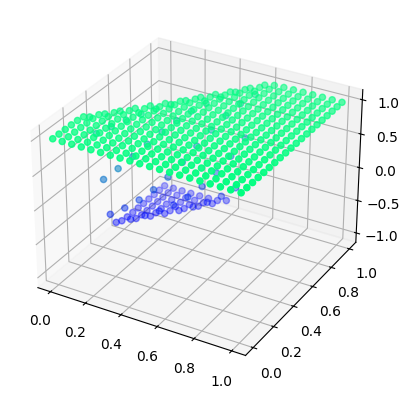

In [18]:
# input's to train XOR on these...
X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

# pseudo network architecture made over here for proper understanding...
network = [
    Dense(2, 3),
    Tanh(),
    Dense(3, 1),
    Tanh()
]

train(network, mse, mse_prime, X, Y, epochs=10000, learning_rate=0.1)

points = []
for x in np.linspace(0, 1, 20):
    for y in np.linspace(0, 1, 20):
        z = predict(network, [[x], [y]])
        points.append([x, y, z[0,0]])


#showing the output of this neral network as a 3D block
points = np.array(points)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
plt.show()

#type this in console to see output
#%run xor.py

In [11]:
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

In [30]:
def preprocess_data(x, y, limit):
    # reshape and normalize input data
    x = x.reshape(x.shape[0], 28 * 28, 1)
    x = x.astype("float32") / 255
    # encode output which is a number in range [0,9] into a vector of size 10
    # e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    y = to_categorical(y)
    y = y.reshape(y.shape[0], 10, 1)
    return x[:limit], y[:limit]


# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 1000)
x_test, y_test = preprocess_data(x_test, y_test, 20)

# neural network
network = [
    Dense(28 * 28, 40),
    Tanh(),
    Dense(40, 10),
    Tanh()
]

# train
train(network, mse, mse_prime, x_train, y_train, epochs=100, learning_rate=0.1)

# test
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print('pred:', np.argmax(output), '\ttrue:', np.argmax(y))

1/100, error=1.0743892592216142
11/100, error=1.2702475104839368
21/100, error=1.2755070449552104
31/100, error=1.2805433555026322
41/100, error=1.2812594343372024
51/100, error=1.2814212601052626
61/100, error=1.2815196731936855
71/100, error=1.2815890291099856
81/100, error=1.2816411403761054
91/100, error=1.2816821222764068
pred: 1 	true: 7
pred: 9 	true: 2
pred: 9 	true: 1
pred: 1 	true: 0
pred: 1 	true: 4
pred: 9 	true: 1
pred: 1 	true: 4
pred: 1 	true: 9
pred: 1 	true: 5
pred: 1 	true: 9
pred: 9 	true: 0
pred: 1 	true: 6
pred: 1 	true: 9
pred: 9 	true: 0
pred: 1 	true: 1
pred: 5 	true: 5
pred: 1 	true: 9
pred: 1 	true: 7
pred: 1 	true: 3
pred: 1 	true: 4


In [15]:

def preprocess_data(x, y, limit):
    zero_index = np.where(y == 0)[0][:limit]
    one_index = np.where(y == 1)[0][:limit]
    all_indices = np.hstack((zero_index, one_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    y = to_categorical(y)
    y = y.reshape(len(y), 2, 1)
    return x, y

# load MNIST from server, limit to 100 images per class since we're not training on GPU
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

# neural network
network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Sigmoid()
]

# train
train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    x_train,
    y_train,
    epochs=20,
    learning_rate=0.1
)

# test
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")

1/20, error=0.4167306903712764
11/20, error=0.0040030333644553604
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0

# **AS WE CAN SEE THAT THE CONV NET PERFORMS SO MUCH BETTER THAN THE NEURAL NET ON THIS MNIST DATASET**

In [ ]:
# Assuming network_nn, network_cnn, x_test_dense, x_test_cnn, and y_test_comp
# are defined and the networks have been trained.

print("\n--- Visual Comparison of NN vs CNN on 0/1 Test Samples ---")
print("-------------------------------------------------------------------------")
print("| Sample | True Label | Dense NN (Pred) | Dense NN (Correct?) | CNN (Pred) | CNN (Correct?) |")
print("-------------------------------------------------------------------------")

nn_correct_count = 0
cnn_correct_count = 0
total_samples = len(x_test_dense)

# Test Loop: Iterate over the shared 0/1 test set.
for i in range(total_samples):
    x_d = x_test_dense[i] # Dense input shape (784, 1)
    x_c = x_test_cnn[i]   # CNN input shape (1, 28, 28)
    y_true = np.argmax(y_test_comp[i]) # True label (0 or 1)

    # 1. Dense Network Prediction
    output_nn_full = predict(network_nn, x_d) # Output is 10 classes
    # We only care about the outputs for classes 0 and 1
    output_nn = output_nn_full[[0, 1]]
    pred_nn = np.argmax(output_nn)

    # 2. CNN Network Prediction
    output_cnn = predict(network_cnn, x_c) # Output is 2 classes
    pred_cnn = np.argmax(output_cnn)

    # 3. Tally Results
    nn_status = "YES" if pred_nn == y_true else "NO"
    cnn_status = "YES" if pred_cnn == y_true else "NO"

    if pred_nn == y_true:
        nn_correct_count += 1
    if pred_cnn == y_true:
        cnn_correct_count += 1

    # Print individual sample results
    print(f"| {i:6} | {y_true:10} | {pred_nn:15} | {nn_status:19} | {pred_cnn:10} | {cnn_status:14} |")

print("-------------------------------------------------------------------------")

# Final Accuracy Calculation
nn_accuracy = (nn_correct_count / total_samples) * 100
cnn_accuracy = (cnn_correct_count / total_samples) * 100

print(f"\nDense NN Accuracy on 0/1 Test Set: {nn_accuracy:.2f}% ({nn_correct_count}/{total_samples})")
print(f"CNN Accuracy on 0/1 Test Set:   {cnn_accuracy:.2f}% ({cnn_correct_count}/{total_samples})")

print("\nOBSERVATION: The significantly higher CNN accuracy demonstrates its ability to extract spatial features using the Convolutional layer, making it far superior for image classification.")

Trying out the ReLU activation fucntion which was added.

In [22]:
def preprocess_data(x, y, limit):
    zero_index = np.where(y == 0)[0][:limit]
    one_index = np.where(y == 1)[0][:limit]
    all_indices = np.hstack((zero_index, one_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), 1, 28, 28)  #reshape in the X as a 4D matrix = Number of Samples/Batch Size * Depth/Channels(RGB/Greysacale) * Height * Width
    x = x.astype("float32") / 255
    y = to_categorical(y)
    y = y.reshape(len(y), 2, 1)       #same kinda reshape but with output having only 2 value to give out [0 , 1] -->
    return x, y

# load MNIST from server, limit to 100 images per class since we're not training on GPU
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 200)
x_test, y_test = preprocess_data(x_test, y_test, 200)

# Convolutional neural network implemnetation we can take 2D matrix as input in this...
network =   [
        Convolutional((1, 28, 28), 3, 5),
        ReLU(),
        Reshape((5, 26, 26), (5 * 26 * 26, 1)),
        Dense(5 * 26 * 26, 100),
        Sigmoid(),
        Dense(100, 2),
        Sigmoid()
]

#Prameters to pass to netwrok class for train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
train(network,binary_cross_entropy,binary_cross_entropy_prime,x_train,y_train,epochs=20,learning_rate=0.1)

# test
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")

1/20, error=0.1796592959846169
11/20, error=0.0064185197721813424
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0

1. The Core Problem: Activation Mismatch
Your error warnings (RuntimeWarning: divide by zero encountered in log, invalid value encountered in divide) stem from the fact that your binary_cross_entropy loss function is mathematically designed to work with probabilities that are bounded between 0 and 1.

The Fixed Network Structure
You should use ReLU for the hidden layers to benefit from faster training, but must use Sigmoid for the final output layer of your binary classification network:

SO NOTE:-->
The fundamental rule is that CCE loss requires its input to be a probability distribution. So not ReLU it should have a singular value as 1 and rest as 0 like softmax , sigmoid etc...

# Now trying to classfiy all the numbers from 0 to 9 using the Categorical cross entropy and the Softmax activation from here on with new Activation Functions for trial of these.

In [38]:
def preprocess_data(x, y, limit):
    x = x.reshape(len(x), 1, 28, 28)  #reshape in the X as a 4D matrix = Number of Samples/Batch Size * Depth/Channels(RGB/Greysacale) * Height * Width
    x = x.astype("float32") / 255
    y = to_categorical(y)
    y = y.reshape(len(y), 10, 1)
    return x[:limit], y[:limit]

# load MNIST from server, limit to 100 images per class since we're not training on GPU
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 1000)
x_test, y_test = preprocess_data(x_test, y_test, 1000)

# Convolutional neural network implemnetation we can take 2D matrix as input in this...
network =  [
        Convolutional((1, 28, 28), 3, 5),
        ReLU(),
        Reshape((5, 26, 26), (5 * 26 * 26, 1)), #when going from CONV to Dense we need to reashape i.e flatten the layer to 1D vec
        Dense(5 * 26 * 26, 100),
        ReLU(),
        Dense(100, 10),
        Softmax()
] # note the input and the output layers are matching the shapes

#Prameters to pass to netwrok class for train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
train(network,categorical_cross_entropy,categorical_cross_entropy_prime,x_train,y_train,epochs=100,learning_rate=0.1)

# test
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")

1/100, error=2.5039184017179354
11/100, error=2.5061336152147473
21/100, error=2.5061336152147473
31/100, error=2.5061336152147473
41/100, error=2.5061336152147473
51/100, error=2.5061336152147473
61/100, error=2.5061336152147473
71/100, error=2.5061336152147473
81/100, error=2.5061336152147473
91/100, error=2.5061336152147473
pred: 3, true: 7
pred: 3, true: 2
pred: 3, true: 1
pred: 3, true: 0
pred: 3, true: 4
pred: 3, true: 1
pred: 3, true: 4
pred: 3, true: 9
pred: 3, true: 5
pred: 3, true: 9
pred: 3, true: 0
pred: 3, true: 6
pred: 3, true: 9
pred: 3, true: 0
pred: 3, true: 1
pred: 3, true: 5
pred: 3, true: 9
pred: 3, true: 7
pred: 3, true: 3
pred: 3, true: 4
pred: 3, true: 9
pred: 3, true: 6
pred: 3, true: 6
pred: 3, true: 5
pred: 3, true: 4
pred: 3, true: 0
pred: 3, true: 7
pred: 3, true: 4
pred: 3, true: 0
pred: 3, true: 1
pred: 3, true: 3
pred: 3, true: 1
pred: 3, true: 3
pred: 3, true: 4
pred: 3, true: 7
pred: 3, true: 2
pred: 3, true: 7
pred: 3, true: 1
pred: 3, true: 2
pred: 3,

In [ ]:
#WE CAN CLEARLY SEE THAT THE NET HAS STOPPED LEARNING AFTER A GIVEN POINT